In [3]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [82]:
import numpy as np
from scipy import stats
from scipy import linalg
from specsens import util

from specsens import TracyWidom

def corr(x, l, prog_bar=True, w_mat=None):
    '''Return correlation matrix'''
    x = np.reshape(x, (-1, 1))
    r = np.zeros((l, l), dtype=np.complex128)
    if prog_bar:
        for i in tqdm.tqdm(range(0, len(x) - l)):
            r += np.dot(x[i:i + l], x[i:i + l].conj().T)
    else:
        for i in range(0, len(x) - l):
            r += np.dot(x[i:i + l], x[i:i + l].conj().T)
    corr_mat = r / (len(x) - l)
    if w_mat is None:
        return corr_mat
    else:
        return np.dot(np.dot(w_mat, corr_mat), w_mat)


def mme_thr(Ns, L, Pfa=0.1, M=1):
    tw = TracyWidom(beta=1)
    fac1 = (Ns**.5 + (M * L)**.5)**2 / (Ns**.5 - (M * L)**.5)**2
    fac2 = 1 + ((Ns**.5 + (M * L)**.5)**(-2 / 3) /
                (Ns * M * L)**(1 / 6)) * tw.cdfinv(1 - Pfa)
    return fac1 * fac2


def mme_pfa(Ns, L, thr, M=1):
    tw = TracyWidom(beta=1)
    mu = ((Ns - 1)**.5 + (M * L)**.5)**2
    v = ((Ns - 1)**.5 + (M * L)**.5) * (1 / ((Ns - 1)**.5) + 1 /
                                        ((M * L)**.5))**(1 / 3)
    fac = (thr * (Ns**.5 - (M * L)**.5)**2. - mu) / v
    return 1 - tw.cdf(fac)


def mme_pd(Ns, L, thr, noise_power, sig_eigv_min, sig_eigv_max, M=1, dB=True):
    if dB:
        noise_power = util.dB_to_factor_power(noise_power)
    tw = TracyWidom(beta=1)
    mu = ((Ns - 1)**.5 + (M * L)**.5)**2
    v = ((Ns - 1)**.5 + (M * L)**.5) * (1 / ((Ns - 1)**.5) + 1 /
                                        ((M * L)**.5))**(1 / 3)
    fac = (thr * Ns +
           (Ns * (thr * sig_eigv_min - sig_eigv_max)) / noise_power - mu) / v
    return 1 - tw.cdf(fac)



def eme_thr(Ns, L, Pfa=0.1, M=1):
    fac1 = (2. / (M * Ns))**.5 * stats.norm.isf(Pfa) + 1
    fac2 = Ns / (Ns**.5 - (M * L)**.5)**2
    return fac1 * fac2


def eme(x, l=10, w_mat=None):
    '''Energy with minimum eigenvalue.'''
    Rx = corr(x, l, prog_bar=False, w_mat=w_mat)
    eigvals = np.abs(linalg.eigvals(Rx))
    energy = np.sum(np.abs(x)**2.) / len(x)
    return energy / np.min(eigvals)



# mme_pd(Ns=10000,
#        L=10,
#        thr=1.13322658,
#        noise_power=20.,
#        sig_eigv_min=1.7389386492015497e-13,
#        sig_eigv_max=12.142347308356868,
#        M=0.977)
# mme_pd(Ns=10000, L=10, thr=1.13322658, noise_power=104.73460166417524, dB=False, sig_eigv_min=0, sig_eigv_max=12.142347308356872, M=0.977)

# thr = mme_thr(Ns=10000, L=10, Pfa=0.1, M=0.977)

# pfa = mme_pfa(Ns=10000, L=10, thr=thr, M=0.977)

# print('thr', thr)
# print('pfa', pfa)

---- Simulation parameters ----
Generations:    100
Iterations:     20
Total iters:    2000
Signal power:   1.00 dB
Sig cent. freq: -100000.0 Hz
Noise power:    17.00 dB
Noise uncert:   0.00 dB
SNR:            -16.00 dB
Signal length:  0.010000 s
Signal samples: 10000
---- Simulation stats theory ----
Prob false alarm: 0.0100
Prob detection:   nan
Threshold:        1.10001854
---- Running simulation ----
Using 8 processes on 8 cores


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


---- Simulation stats ----
Prob false alarm theory: 0.0100
Prob false alarm sim:    0.0000
Prob detection theory:   nan
Prob detection sim:      0.0000


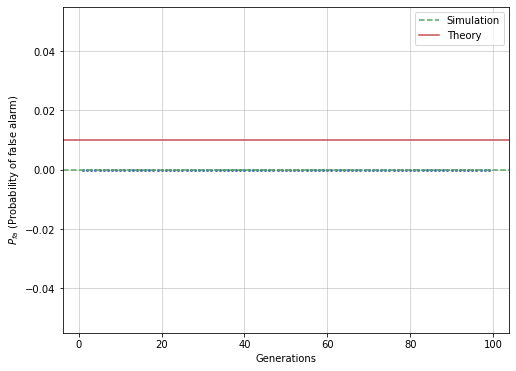

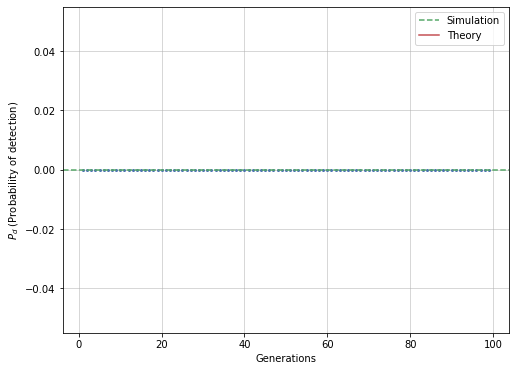

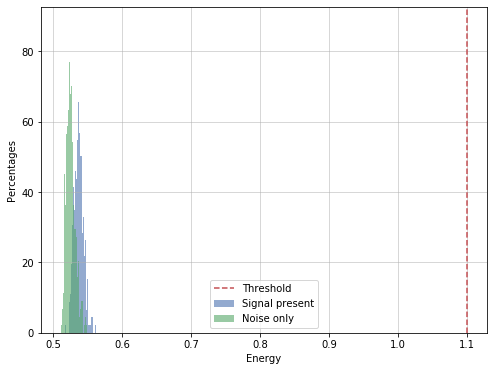

---- Distribution stats ----
Sig present mean: 0.5374
Sig absent  mean: 0.5255
Sig present var:  0.0000
Sig absent  var:  0.0000
Sig present std:  0.0068
Sig absent  std:  0.0066


In [83]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import multiprocessing as mp
import tqdm
from functools import partial

from specsens import util
from specsens import util_sim
from specsens import WirelessMicrophone
from specsens import WhiteGaussianNoise
from specsens import eigen_detector
from specsens import eigen_stats


def generation(f_sample, length_sec, itrs, noise_power, signal_power,
               noise_uncert, threshold, f_center, cov_size, seeds):

    # create new signal objects
    wm = WirelessMicrophone(f_sample=f_sample, t_sec=length_sec, seed=seeds[0])
    wgn = WhiteGaussianNoise(f_sample=f_sample,
                             t_sec=length_sec,
                             seed=seeds[1])

    # local rng
    rng = np.random.default_rng(seeds[2])

    # calculate noise power with uncertainty
    gen_noise_power = rng.normal(loc=noise_power, scale=noise_uncert)

    # store results in 'result' array energies in 'energy' array
    result = np.array([])
    energy = np.array([])

    # list for noise estimation
    noise_est_list = np.array([])

    # 'inner' interations loop
    for _ in range(itrs):

        # generate signal
        sig = wm.soft(f_center=f_center, power=signal_power, dB=True)

        # generate noise
        noise = wgn.signal(power=gen_noise_power, dB=True)

        # randomly decide whether signal should be present
        sig_present = rng.choice([True, False])
        if sig_present:
            both = sig + noise
        else:
            both = noise


#         # maximum-minimum eigenvalue detector
#         eng = eigen_detector.mme(x=both, l=cov_size)

# energy with minimum eigenvalue
        eng = eme(x=both, l=cov_size)

        # threshold
        sig_detected = eng > threshold

        # log detection outcome
        if sig_present and sig_detected:
            result = np.append(result, 1)
        elif sig_present and not sig_detected:
            result = np.append(result, 2)
        elif not sig_present and sig_detected:
            result = np.append(result, 3)
        else:
            result = np.append(result, 4)

        # log energy
        energy = np.append(energy, eng)

    # calculate statistics and store in arrays
    pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) + np.sum(result == 4))
    pd_tmp = np.sum(result == 1) / (np.sum(result == 1) + np.sum(result == 2))

    return pfa_tmp, pd_tmp, energy, result, gen_noise_power


def eigenvalue_sim(
        gens=50,  # generations, number of environments
        itrs=300,  # iterations, number of tests in each environment
        f_sample=1e6,  # in Hz
        signal_power=0.,  # in dB
        f_center=-1e5,  # signal center frequency
        noise_power=0.,  # in dB
        length_sec=None,  # length of each section in seconds
        num_samples=None,  # number of samples
        theo_pfa=0.1,  # probability of false alarm
        threshold=None,  # threshold used for detection
        noise_uncert=0.0,  # standard deviation of the noise normal distribution
        seed=None,  # random seed used for rng
        num_procs=None,  # number of processes to run in parallel
        cov_size=10,  # covariance matrix size
        sampling_factor=1.):  # sampling factor

    # set number of processes used
    if num_procs is None:
        num_procs = mp.cpu_count()
    assert num_procs > 0, 'num_procs must be greater than 0'
    assert num_procs <= gens, 'num_procs must be less or equal to gens'

    # check and calculate length (in seconds and number of samples)
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    # calculate threshold
    if threshold is None:
        #         threshold = mme_thr(Ns=num_samples,
        #                             L=cov_size,
        #                             Pfa=theo_pfa,
        #                             M=sampling_factor)
        threshold = eme_thr(Ns=num_samples,
                            L=cov_size,
                            Pfa=theo_pfa,
                            M=sampling_factor)

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Sig cent. freq: %.1f Hz' % (f_center))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert:   %.2f dB' % (noise_uncert))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f s' % (length_sec))
    print('Signal samples: %d' % (num_samples))

    # calculate pd (only needed for prints)
    #     theo_pd = est_stats.pd(noise_power,
    #                            signal_power,
    #                            threshold,
    #                            n=fft_len / num_bands,
    #                            m=(fft_len / num_bands) * noise_est_hist,
    #                            num_bands=num_bands)
    theo_pd = float('nan')

    print('---- Simulation stats theory ----')
    print('Prob false alarm: %.4f' % (theo_pfa))
    print('Prob detection:   %.4f' % (theo_pd))
    print('Threshold:        %.8f' % (threshold))

    print('---- Running simulation ----')
    print('Using %d processes on %d cores' % (num_procs, mp.cpu_count()))

    pfas = list()  # probability of false alarm list
    pds = list()  # probability of detection list
    current_time = None  # time variable used for 'runtime_stats'

    # generate child seeds for wm and wgn
    seed_seq = np.random.SeedSequence(seed)
    seeds = list(
        zip(seed_seq.spawn(gens), seed_seq.spawn(gens), seed_seq.spawn(gens)))

    # prepare parallel execution
    p = mp.Pool(processes=num_procs)
    f = partial(generation, f_sample, length_sec, itrs, noise_power,
                signal_power, noise_uncert, threshold, f_center, cov_size)

    # run simulation while showing progress bar
    res = list(tqdm.tqdm(p.imap(f, seeds), total=gens))

    # cleanup parallel execution
    p.close()
    p.join()

    # 'unwrap' res tuples
    pfas = [r[0] for r in res]
    pds = [r[1] for r in res]
    energies = np.ravel([r[2] for r in res])
    results = np.ravel([r[3] for r in res])
    gen_noise_powers = np.ravel([r[4] for r in res])

    # compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    # compute energy distributions
    engs_both = energies[np.where(results <= 2)[0]]
    engs_noise = energies[np.where(results > 2)[0]]

    print('---- Simulation stats ----')
    print('Prob false alarm theory: %.4f' % (theo_pfa))
    print('Prob false alarm sim:    %.4f' % (pfa))
    print('Prob detection theory:   %.4f' % (theo_pd))
    print('Prob detection sim:      %.4f' % (pd))

    # print the convergence diagrams
    util_sim.print_convergence(gens, pfas, pds, theo_pfa, theo_pd)

    # print energy distributions
    util_sim.print_distribution(engs_both,
                                engs_noise,
                                num_samples,
                                threshold=threshold,
                                hist_only=True)

    return pfa, pd


# eigenvalue detector simulation using mme

_ = eigenvalue_sim(
    gens=100,  # generations, number of environments
    itrs=20,  # iterations, number of tests in each environment
    f_sample=1e6,  # in Hz
    signal_power=1.0,  # in dB
    noise_power=17.0,  # in dB
    length_sec=0.01,  # length of each sample in seconds
    theo_pfa=0.01,  # probability of false alarm
    noise_uncert=0.0,  # standard deviation of the noise normal distribution
    num_procs=None,  # number of processes to run in parallel
    seed=None,  # set seed for reproducibility
    cov_size=10,  # covariance matrix size
    #     sampling_factor=0.977)
    sampling_factor=0.92)

# there is no probability of detection statistics yet...